In [5]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import statsmodels.api as sm
import numpy as np

import warnings
warnings.filterwarnings('ignore')


#read the data
df = pd.read_csv("Dasatest.csv",infer_datetime_format=True,)

#check the dtypes
df.dtypes


Month           object
Region 1       float64
Region 2       float64
Region 3       float64
Region 4       float64
                ...   
Region 3911    float64
Region 3912    float64
Region 3913    float64
Region 3914    float64
Region 3915    float64
Length: 3916, dtype: object

In [6]:
df['Month'] = pd.to_datetime(df.Month , format = '%d/%m/%Y')
data = df.drop(['Month'], axis=1)
data.index = df.Month
data

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,Region 7,Region 8,Region 9,Region 10,...,Region 3906,Region 3907,Region 3908,Region 3909,Region 3910,Region 3911,Region 3912,Region 3913,Region 3914,Region 3915
Month,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.154325,0.119708,0.178236,0.225016,0.318976,0.049922,0.219802,0.069055,0.186616,0.053525,...,0.154372,0.338739,0.253205,0.233119,0.199864,3.400484,0.374751,0.463527,1.641510,0.307089
2013-01-02,0.122901,0.119831,0.165497,0.220602,0.316835,0.082337,0.175329,0.059602,0.185539,0.050294,...,0.180818,0.424401,0.336452,0.290894,0.328968,3.999567,0.478654,0.571315,1.649937,0.451604
2013-01-03,0.127583,0.112970,0.190754,0.224240,0.328486,0.083182,0.178562,0.071814,0.207523,0.060354,...,0.407456,0.485308,0.369691,0.301755,0.271360,3.308452,0.501871,0.644025,2.110449,0.448063
2013-01-04,0.501557,0.326049,0.321733,0.330916,0.483001,0.156701,0.245769,0.123014,0.364449,0.115983,...,0.403261,0.473134,0.376600,0.358181,0.447163,2.636698,0.481275,0.636814,1.642345,0.464692
2013-01-05,0.103551,0.098852,0.203126,0.268934,0.380898,0.013289,0.139204,0.078820,0.165327,0.072806,...,0.334762,0.357057,0.402745,0.304655,0.260061,2.191918,0.436495,0.496774,1.002016,0.384780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-08,0.234171,0.218367,0.263643,0.228902,0.289498,0.182184,0.338011,0.174733,0.233715,0.164643,...,0.543904,0.485205,0.373730,0.438972,0.289112,2.733757,0.551515,0.560397,1.043067,0.467049
2018-01-09,0.294693,0.275179,0.296751,0.291502,0.368923,0.254764,0.312503,0.223991,0.325548,0.222239,...,0.570894,0.546334,0.498556,0.499537,0.392619,2.472169,0.604042,0.737536,1.123075,0.546029
2018-01-10,0.373754,0.344997,0.400269,0.364874,0.416527,0.274649,0.441609,0.307967,0.356959,0.299287,...,0.940555,0.864838,0.792921,0.841714,0.558779,3.531807,0.972735,1.207824,1.773948,0.817059


In [7]:
cols = data.columns

In [8]:
# ad_fuller_result_1 = adfuller(df['Region 2'].diff()[1:])

# print('realgdp')
# print(f'ADF Statistic: {ad_fuller_result_1[0]}')
# print(f'p-value: {ad_fuller_result_1[1]}')


realgdp
ADF Statistic: -7.14603510829026
p-value: 3.2310054388452854e-10


In [9]:
train = data[:int(0.834*(len(data)))]
valid = data[int(0.834*(len(data))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_percentage_error

model = VAR(endog=train)
model_fit = model.fit(1)
predictions = model_fit.forecast(model_fit.y, steps=len(valid))

# var_model = VARMAX(train, order=(1,0), enforce_stationarity= True)
# fitted_model = var_model.fit(disp=False)
# print(fitted_model.summary())

# print(train.shape)

# #converting predictions to dataframe

# sum1 = 0 

# pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
# for j in range(0,3915):
#     for i in range(0, len(prediction)):
#        pred.iloc[i][j] = prediction[i][j]

# #check mape
# for i in cols:
#     print('rmse value for', i, 'is : ', mean_absolute_percentage_error(pred.loc[:,[i]] ,valid.loc[:,[i]]))
#     sum1 += mean_absolute_percentage_error(pred.loc[:,[i]] ,valid.loc[:,[i]])



In [10]:
# n_forecast = 12
# predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)
# predictions=predict.predicted_mean
# print(predictions)

(12, 3915)
0.14054811603923364
(12, 3915)


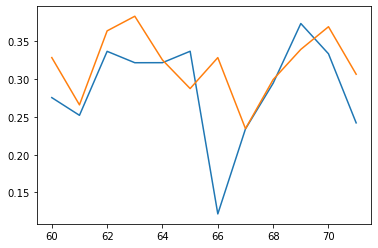

In [11]:
time= np.arange(60,72)
print(valid.shape)
plt.plot(time,valid.iloc[:,0])
plt.plot(time,predictions[:,0])
print(mean_absolute_percentage_error(predictions[:,0],valid.iloc[:,0]))
valid_diff = valid - predictions 
print(valid_diff.shape)

In [ ]:
print(sum1)

In [ ]:
#make final predictions
model = VAR(endog=data.diff()[1:])
model_fit = model.fit(11)
yhat = model_fit.forecast(model_fit.y, steps=15)
print(yhat)

In [ ]:
output = pd.DataFrame(yhat)
output.to_csv('submission_0.csv')
print("Your submission was successfully saved!")